Using device: cpu
Training set size: 60000
Test set size: 10000
Input feature dimension: 784
Number of classes: 10


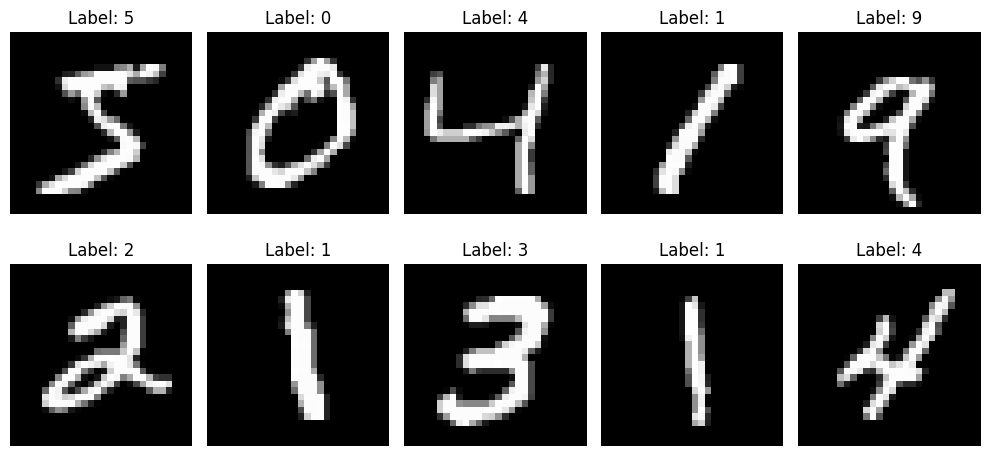

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Download and load the data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Reshape data for KAN - flatten the images
X_train = train_dataset.data.float().view(-1, 28*28) / 255.0
y_train = train_dataset.targets
X_test = test_dataset.data.float().view(-1, 28*28) / 255.0
y_test = test_dataset.targets

# Create data loaders
batch_size = 256
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Input feature dimension: {X_train.shape[1]}")
print(f"Number of classes: {len(train_dataset.classes)}")

# Display some sample images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_dataset.data[i], cmap='gray')
    plt.title(f"Label: {train_dataset.targets[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
class BSpline(nn.Module):
    """B-spline basis functions implementation"""
    def __init__(self, num_basis=10, degree=3, range_min=0.0, range_max=1.0):
        super().__init__()
        self.num_basis = num_basis
        self.degree = degree
        self.range_min = range_min
        self.range_max = range_max
        
        # Calculate knot vector with appropriate padding for the spline degree
        self.knots = self._create_knot_vector()
        
    def _create_knot_vector(self):
        """Create an open knot vector appropriate for the spline degree"""
        # Interior knots
        interior_knots = torch.linspace(self.range_min, self.range_max, self.num_basis - self.degree + 1)
        
        # Pad the knot vector with repeated boundary knots
        prefix = torch.ones(self.degree) * self.range_min
        suffix = torch.ones(self.degree) * self.range_max
        
        knots = torch.cat([prefix, interior_knots, suffix])
        return knots
    
    def _basis_function_recursive(self, i, p, x):
        """Recursive definition of B-spline basis functions of degree p"""
        # Base case: degree 0
        if p == 0:
            return ((x >= self.knots[i]) & (x < self.knots[i+1])).float()
        
        # Recursive case
        term1 = torch.zeros_like(x)
        term2 = torch.zeros_like(x)
        
        # First term
        denom1 = self.knots[i+p] - self.knots[i]
        if denom1 > 0:
            num1 = x - self.knots[i]
            term1 = num1 / denom1 * self._basis_function_recursive(i, p-1, x)
        
        # Second term
        denom2 = self.knots[i+p+1] - self.knots[i+1]
        if denom2 > 0:
            num2 = self.knots[i+p+1] - x
            term2 = num2 / denom2 * self._basis_function_recursive(i+1, p-1, x)
        
        return term1 + term2
        
    def forward(self, x):
        """
        Compute all B-spline basis functions for the given input
        
        Args:
            x: Input tensor of shape (batch_size, 1)
            
        Returns:
            Tensor of shape (batch_size, num_basis) containing the basis function values
        """
        batch_size = x.shape[0]
        
        # Handle boundary case
        x = torch.clamp(x, self.range_min, self.range_max - 1e-6)
        
        # Compute each basis function for all inputs
        basis_values = torch.zeros(batch_size, self.num_basis, device=x.device)
        
        for i in range(self.num_basis):
            basis_values[:, i] = self._basis_function_recursive(i, self.degree, x.squeeze())
            
        return basis_values

In [8]:
class KolmogorovArnoldLayer(nn.Module):
    """
    Single layer of Kolmogorov-Arnold Network with B-spline basis functions
    
    Implements the layer based on the Kolmogorov-Arnold representation theorem:
    f(x₁,...,xₙ) = ∑ᵢ gᵢ(∑ⱼ ϕᵢⱼ(xⱼ))
    """
    def __init__(self, in_features, out_features, num_basis=10, degree=3):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_basis = num_basis
        
        # Inner transformation functions ϕᵢⱼ
        # Weights and biases for linear transformation before applying basis functions
        self.inner_weights = nn.Parameter(torch.Tensor(out_features, in_features))
        self.inner_biases = nn.Parameter(torch.Tensor(out_features))
        
        # B-spline basis functions
        self.basis_functions = BSpline(num_basis=num_basis, degree=degree)
        
        # Outer transformation weights
        self.outer_weights = nn.Parameter(torch.Tensor(out_features, num_basis))
        
        # Initialize parameters
        self._initialize_parameters()
        
    def _initialize_parameters(self):
        # Initialize weights using Kaiming/He initialization
        nn.init.kaiming_uniform_(self.inner_weights, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.outer_weights, a=np.sqrt(5))
        
        # Initialize biases
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.inner_weights)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.inner_biases, -bound, bound)
        
    def forward(self, x):
        """
        Forward pass for the KAN layer
        
        Args:
            x: Input tensor of shape (batch_size, in_features)
            
        Returns:
            Output tensor of shape (batch_size, out_features)
        """
        batch_size = x.shape[0]
        
        # Apply inner transformations (ϕᵢⱼ(xⱼ))
        # Transform each input: z_ij = w_ij * x_j + b_i
        inner_transformed = torch.zeros(batch_size, self.out_features, device=x.device)
        
        for i in range(self.out_features):
            # Linear transformation: z_i = W_i * x + b_i
            z_i = F.linear(x, self.inner_weights[i:i+1], self.inner_biases[i:i+1])
            inner_transformed[:, i:i+1] = z_i
        
        # Apply basis functions to the inner transformations
        # Normalize to [0, 1] range for the spline evaluation
        normalized_inner = torch.sigmoid(inner_transformed)
        
        # Get basis function values for each output dimension
        basis_values = torch.zeros(batch_size, self.out_features, self.num_basis, device=x.device)
        
        for i in range(self.out_features):
            basis_values[:, i] = self.basis_functions(normalized_inner[:, i:i+1])
        
        # Apply outer transformations (linear combination of basis functions)
        output = torch.zeros(batch_size, self.out_features, device=x.device)
        
        for i in range(self.out_features):
            output[:, i] = torch.sum(basis_values[:, i] * self.outer_weights[i], dim=1)
        
        return output


class KolmogorovArnoldNetwork(nn.Module):
    """
    Multi-layer Kolmogorov-Arnold Network for MNIST classification
    """
    def __init__(self, in_features, hidden_features, num_classes, num_basis=10, degree=3):
        super().__init__()
        
        # First KAN layer (input to hidden)
        self.layer1 = KolmogorovArnoldLayer(
            in_features=in_features, 
            out_features=hidden_features, 
            num_basis=num_basis, 
            degree=degree
        )
        
        # Output layer - linear mapping to class scores
        self.output_layer = nn.Linear(hidden_features, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)  # Activation between layers
        x = self.output_layer(x)
        return x

In [9]:
# Define the KAN model
in_features = 28 * 28
hidden_features = 64
num_classes = 10
num_basis = 16
degree = 3

model = KolmogorovArnoldNetwork(
    in_features=in_features,
    hidden_features=hidden_features,
    num_classes=num_classes,
    num_basis=num_basis,
    degree=degree
)
model = model.to(device)

print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress
        if (i+1) % 20 == 0:
            print(f"Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Evaluation loop
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Train the model
num_epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

start_time = time.time()

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 50)

# Total training time
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Number of parameters: 51914
Starting training...
Epoch 1/10
Batch 20/235, Loss: 2.0890
Batch 40/235, Loss: 1.9203
Batch 60/235, Loss: 1.7191
Batch 80/235, Loss: 1.4818
Batch 100/235, Loss: 1.2492
Batch 120/235, Loss: 1.0047
Batch 140/235, Loss: 0.7995
Batch 160/235, Loss: 0.7319
Batch 180/235, Loss: 0.5449
Batch 200/235, Loss: 0.5306
Batch 220/235, Loss: 0.4586
Train Loss: 1.1672, Train Acc: 0.8405
Val Loss: 0.4153, Val Acc: 0.9110
--------------------------------------------------
Epoch 2/10
Batch 20/235, Loss: 0.3552
Batch 40/235, Loss: 0.4181
Batch 60/235, Loss: 0.2834
Batch 80/235, Loss: 0.3389
Batch 100/235, Loss: 0.2778
Batch 120/235, Loss: 0.3348
Batch 140/235, Loss: 0.2502
Batch 160/235, Loss: 0.2157
Batch 180/235, Loss: 0.2165
Batch 200/235, Loss: 0.2131
Batch 220/235, Loss: 0.1572
Train Loss: 0.3067, Train Acc: 0.9241
Val Loss: 0.2443, Val Acc: 0.9323
--------------------------------------------------
Epoch 3/10
Batch 20/235, Loss: 0.2669
Batch 40/235, Loss: 0.2772
Batch 60/2

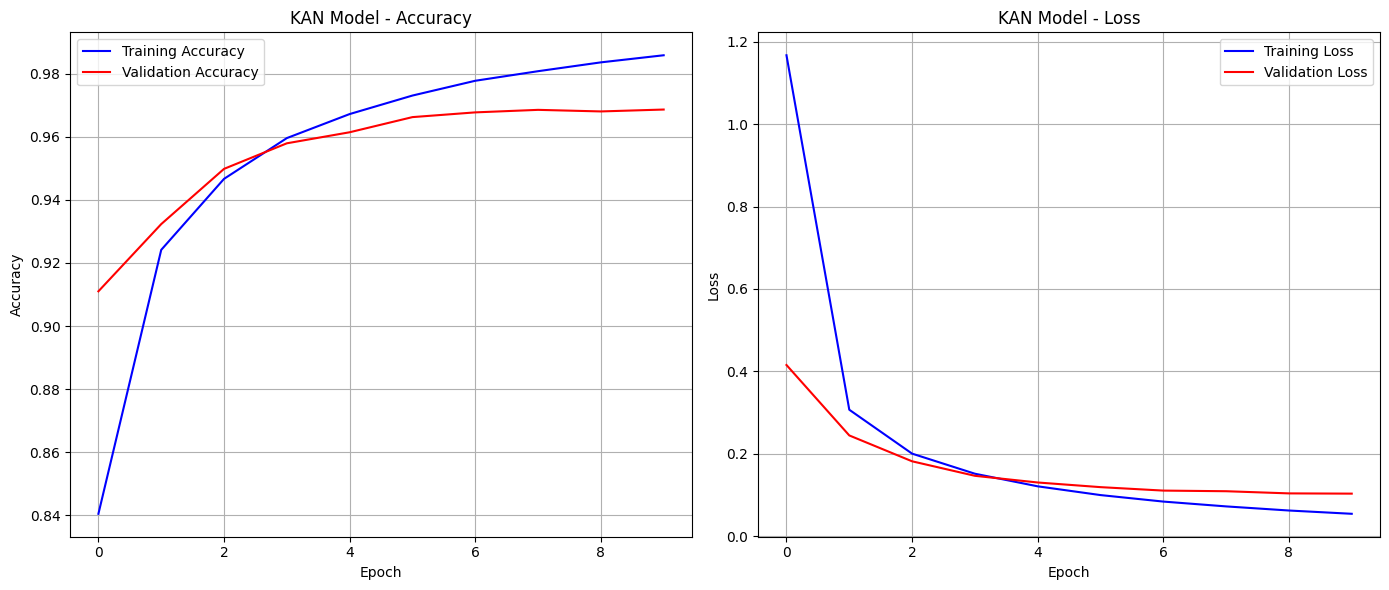

Test Loss: 0.1030, Test Accuracy: 0.9686


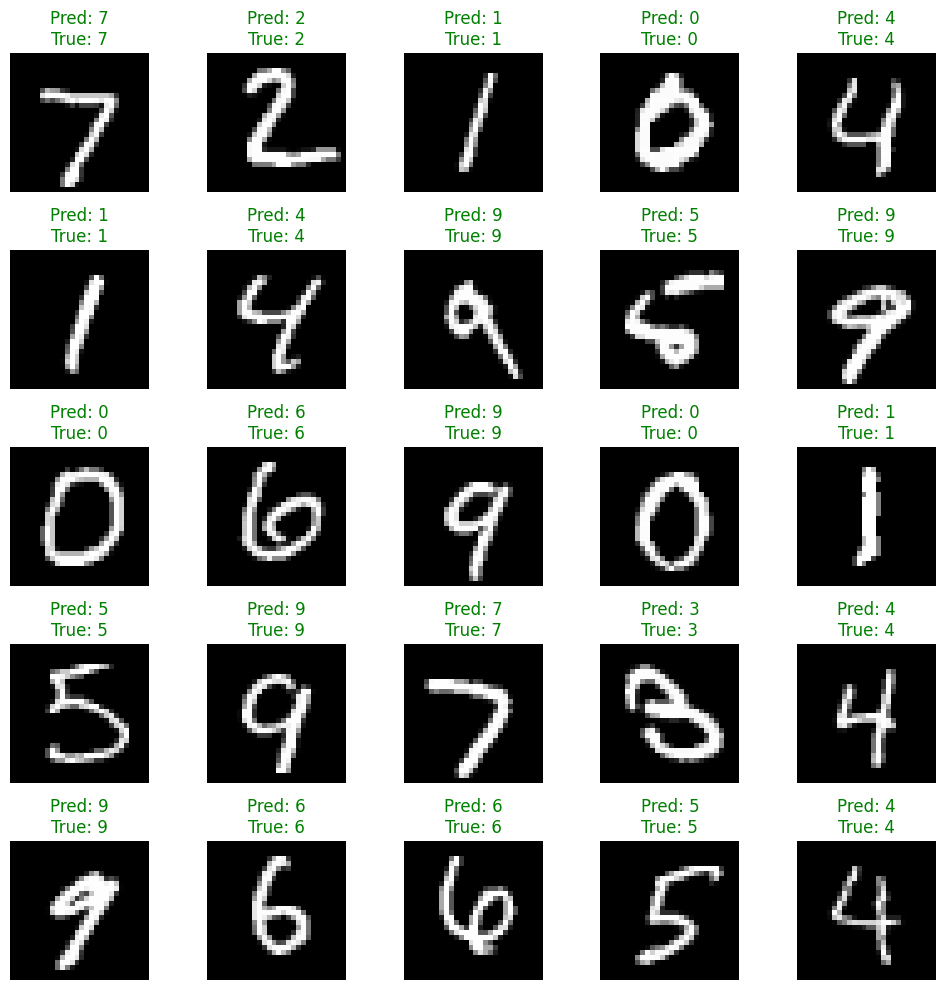

In [10]:
# Plot training and validation curves
plt.figure(figsize=(14, 6))

# Plot accuracy curve
plt.subplot(1, 2, 1)
plt.plot(train_accs, 'b-', label='Training Accuracy')
plt.plot(val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('KAN Model - Accuracy')
plt.legend()
plt.grid(True)

# Plot learning curves
plt.subplot(1, 2, 2)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('KAN Model - Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Detailed evaluation on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Analyze performance on individual test samples
model.eval()
test_images = []
predictions = []
true_labels = []

with torch.no_grad():
    # Get a batch of test samples
    test_batch = next(iter(test_loader))
    inputs, labels = test_batch
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Get model predictions
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    # Store results
    test_images = inputs.cpu().numpy()
    predictions = preds.cpu().numpy()
    true_labels = labels.cpu().numpy()

# Visualize some predictions
plt.figure(figsize=(10, 10))
num_samples = min(25, len(predictions))

for i in range(num_samples):
    plt.subplot(5, 5, i+1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    
    # Color based on correct/incorrect prediction
    color = 'green' if predictions[i] == true_labels[i] else 'red'
    plt.title(f"Pred: {predictions[i]}\nTrue: {true_labels[i]}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

The KAN worked very well on the MNIST dataset, with high precision and steady decline of the loss, as expected.

**Quantum KAN Outlooks

A Quantum Kolmogorov-Arnold Network (QKAN) could extend the classical KAN by replacing traditional B-spline basis functions with parameterized quantum circuits. 

1.Input: Encode input data as quantum states through amplitude encoding or angle embedding techniques. Each basis function would be realized as a variational quantum circuit with rotation gates and entangling operations. 

2.Transformation: Map classical inputs to quantum circuit parameters, controlling rotation angles within the circuits. The quantum circuit outputs serve as the basis function values. These values would then be classically combined through trainable weights to produce the final output.

3.Training: Employ a hybrid quantum-classical approach, using parameter-shift rules to estimate gradients for the quantum components. 

This QKAN architecture might offer advantages for complex pattern recognition problems where quantum superposition and entanglement could enable more efficient function approximation than classical models.